# Import Packages

In [78]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange, tqdm
import h5py
from itertools import product, zip_longest
import torch

# Define Parameters

In [79]:
SNR = 175
n_elements = 128
d_start = 4
d_increment = 4

ob_weight = 100
Nth = 10

n_noise_realizations = 10
n_datasets = 5

lambdaA = -7
lambdaB = 3
default_lambdas = np.append(0, np.logspace(lambdaA,lambdaB,51))

GSS_tolerance = 10**-4

goldRat = (5**(1/2)-1)/2
est_GSS_steps = np.ceil((np.log(GSS_tolerance) - np.log(lambdaB-lambdaA))/np.log(goldRat))+1
print(est_GSS_steps)

tdata = np.linspace(d_start, d_increment*n_elements, n_elements)
assert(tdata[0]==d_start)
assert(tdata[-1]==d_increment*n_elements)

############
#Test case to ensure everything is working
lambdas_test = np.logspace(lambdaA, lambdaB, int(est_GSS_steps))
lambdas_comprehensive = np.logspace(lambdaA, lambdaB, 151)

noise_sd_test = 1/10

c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 100

upper_bound = [1,1,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial_params = np.array([c1, c2, T21, T22]) #Set initial guesses
# initial_params = (0.5, 0.5, 250, 750) #Arbitrary params
# agg_array = np.array([1,1,1/ob_weight, 1/ob_weight])
agg_array = np.array(1/initial_params)

############
#Actual parameter sets to investigate
noise_sd = 1/SNR

c1_set = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
c2_set = 1 - c1_set
T21_set = np.array([10, 20, 30, 40, 50, 60])
T22_set = np.array([70, 85, 100, 120, 150, 200])
n_param_sets = c1_set.size * T21_set.size * T22_set.size

SNR_set = np.array([10, 50, 100, 175, 300])

plt.style.use('default')

25.0


# Define Signal Functions

In [80]:
#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, agg_arr = agg_array):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    agg_arr = lam*agg_arr
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [con1, con2, tau1,tau2]*agg_arr)
    return Gt_lam

def noise(sd):
    return np.random.normal(0, sd, n_elements)

def add_noise(signal, SNR):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    noise_sd = signal[0]/SNR
    noisy_signal = signal + np.random.normal(0, noise_sd, signal_length)
    return noisy_signal

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, noise_sd):
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2)
    covariance = np.linalg.inv(jacobians)
    return noise_sd**2*covariance

# Define Regularization and Estimation Functions

In [81]:
def estimate_parameters(data, lam, init_p0 = initial_params):
    data_tilde = np.append(data, [0,0,0,0])
    
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=init_p0, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
        
    return c1est, c2est, T21est, T22est

def min_lambda(data, c1, c2, T21, T22, lambdas = default_lambdas, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda
    
def find_minLambda_omni_L2(noisey_data, c1, c2, T21, T22, lambdas = default_lambdas, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(noisey_data, lam))
        estimates.append(est)
        error = np.linalg.norm(agg_arr*(est-p_true))
        abs_error_list.append(error)
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def find_minLambda_omni_L1(noisey_data, c1, c2, T21, T22, lambdas = default_lambdas, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(noisey_data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def find_minLambda_GSS_omni(noisey_data, c1, c2, T21, T22, tolerance = GSS_tolerance, lambdaA = lambdaA, lambdaB = lambdaB, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    goldRat = (5**(1/2)-1)/2

    lambdaList = []
    errorList = []
    paramEstimates = []

    lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
    lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)

    lambdaList.append(10**lam_low)
    lambdaList.append(10**lam_high)

    #Getting an initial measure of the parameters 
    est_low = np.array(estimate_parameters(noisey_data, 10**lam_low))
    est_high = np.array(estimate_parameters(noisey_data, 10**lam_high))

    paramEstimates.append(est_low)
    paramEstimates.append(est_high)

    error_low = np.linalg.norm(agg_arr*(est_low-p_true))
    error_high = np.linalg.norm(agg_arr*(est_high-p_true))

    errorList.append(error_low)
    errorList.append(error_high)

    regionThreshold = np.abs(lam_high-lam_low)
    while regionThreshold>tolerance:

        if error_low > error_high:
            lambdaA = lam_low
            lam_low = lam_high
            lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            lambdaList.append(10**lam_high)

            est_high = np.array(estimate_parameters(noisey_data, 10**lam_high))
            paramEstimates.append(est_high)

            error_low = error_high
            error_high = np.linalg.norm(agg_arr*(est_high-p_true))
            errorList.append(error_high)

        else:
            lambdaB = lam_high
            lam_high = lam_low
            lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            lambdaList.append(10**lam_low)

            est_low = np.array(estimate_parameters(noisey_data, 10**lam_low))
            paramEstimates.append(est_low)

            error_high = error_low
            error_low = np.linalg.norm(agg_arr*(est_low-p_true))
            errorList.append(error_low)
        regionThreshold = np.abs(lam_high-lam_low)
    
    min_error_est = paramEstimates[-1]
    min_error_lambda = lambdaList[-1]

    return min_error_est, min_error_lambda, lambdaList, errorList

def find_minLambda_GSS_quick(noisey_data, c1, c2, T21, T22, tolerance = GSS_tolerance, lambdaA = lambdaA, lambdaB = lambdaB, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    goldRat = (5**(1/2)-1)/2

    lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
    lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)

    ret_lambda = 0
    ret_param = 0

    #Getting an initial measure of the parameters 
    est_low = np.array(estimate_parameters(noisey_data, 10**lam_low))
    est_high = np.array(estimate_parameters(noisey_data, 10**lam_high))

    error_low = np.linalg.norm(agg_arr*(est_low-p_true))
    error_high = np.linalg.norm(agg_arr*(est_high-p_true))

    regionThreshold = np.abs(lam_high-lam_low)
    while regionThreshold>tolerance:

        if error_low > error_high:
            lambdaA = lam_low
            lam_low = lam_high
            lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            ret_lambda = 10**lam_high
            est_high = np.array(estimate_parameters(noisey_data, 10**lam_high))
            ret_param = est_high

            error_low = error_high
            error_high = np.linalg.norm(agg_arr*(est_high-p_true))

        else:
            lambdaB = lam_high
            lam_high = lam_low
            lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            ret_lambda = 10**lam_low
            est_low = np.array(estimate_parameters(noisey_data, 10**lam_low))
            ret_param = est_low

            error_high = error_low
            error_low = np.linalg.norm(agg_arr*(est_low-p_true))
        regionThreshold = np.abs(lam_high-lam_low)
    
    min_error_est = ret_param
    min_error_lambda = ret_lambda

    return min_error_est, min_error_lambda

# Visualize Minimum Lambda - Grid Method

'RSS of unregularized = 2.80e-02'

'RSS of L2 lambda_opt = 3.22e-02'

'RSS of L1 lambda_opt = 3.22e-02'

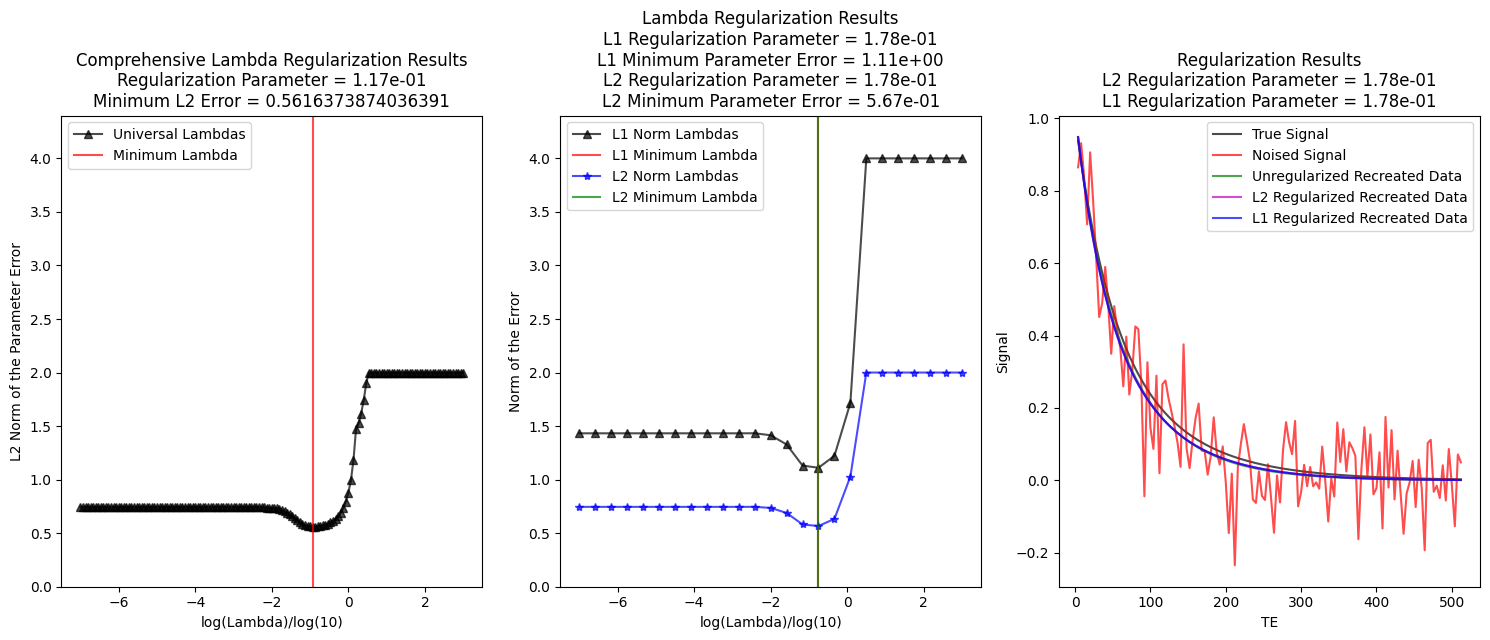

In [82]:
noiseless_curve = G(tdata, c1, c2, T21, T22)

data = noiseless_curve + noise(noise_sd_test)

unreg_params = estimate_parameters(data, 0)

opt_params_comp, min_error_lambda_comp, error_array_comp = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_comprehensive)
opt_params_L2, min_error_lambda_L2, error_array_L2 = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_test)
opt_params_L1, min_error_lambda_L1, error_array_L1 = find_minLambda_omni_L1(data, c1, c2, T21, T22, lambdas = lambdas_test)

unreg_curve = G(tdata, *unreg_params)
recreated_curve_L2 = G(tdata, *opt_params_L2)
recreated_curve_L1 = G(tdata, *opt_params_L1)

unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2)
recreated_RSS_L2 = np.sum((noiseless_curve - recreated_curve_L2)**2)
recreated_RSS_L1 = np.sum((noiseless_curve - recreated_curve_L1)**2)

display('RSS of unregularized = ' + "{:.2e}".format(unreg_RSS))
display('RSS of L2 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L2))
display('RSS of L1 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L1))

opt_ymax = 1.1*np.max([np.max(error_array_L1),np.max(error_array_L2),np.max(error_array_comp)])

fig, ax = plt.subplots(1,3,figsize=(15,6.5), tight_layout=True)
ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=np.log10(min_error_lambda_comp), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[0].set_xlabel('log(Lambda)/log(10)')
ax[0].set_ylabel('L2 Norm of the Parameter Error')
ax[0].set_ylim((0,opt_ymax))
ax[0].set_title('Comprehensive Lambda Regularization Results' + 
                '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_comp) + '\nMinimum L2 Error = ' + str(np.min(error_array_comp)))
ax[0].legend()

ax[1].plot(np.log10(lambdas_test), error_array_L1, label = 'L1 Norm Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axvline(x=np.log10(min_error_lambda_L1), label = 'L1 Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[1].plot(np.log10(lambdas_test), error_array_L2, label = 'L2 Norm Lambdas', alpha = 0.7, color ='b', ls = '-', marker = '*')
ax[1].axvline(x=np.log10(min_error_lambda_L2), label = 'L2 Minimum Lambda', alpha = 0.7, color ='g', ls = '-')
ax[1].set_xlabel('log(Lambda)/log(10)')
ax[1].set_ylabel('Norm of the Error')
ax[1].set_ylim((0,opt_ymax))
ax[1].set_title('Lambda Regularization Results' 
                + '\nL1 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1)
                + '\nL1 Minimum Parameter Error = {:.2e}'.format(np.min(error_array_L1))
                + '\nL2 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2)
                + '\nL2 Minimum Parameter Error = {:.2e}'.format(np.min(error_array_L2)))
ax[1].legend()


ax[2].plot(tdata, noiseless_curve, label = 'True Signal', alpha = 0.7, color ='k', ls = '-')
ax[2].plot(tdata, data, label = 'Noised Signal', alpha = 0.7, color ='r', ls = '-')
ax[2].plot(tdata, unreg_curve, label = 'Unregularized Recreated Data', alpha = 0.7, color ='g', ls = '-')
ax[2].plot(tdata, recreated_curve_L2, label = 'L2 Regularized Recreated Data', alpha = 0.7, color ='m', ls = '-')
ax[2].plot(tdata, recreated_curve_L1, label = 'L1 Regularized Recreated Data', alpha = 0.7, color ='b', ls = '-')
ax[2].set_xlabel('TE')
ax[2].set_ylabel('Signal')
ax[2].set_title('Regularization Results' + '\nL2 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2) + 
            '\nL1 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1))
ax[2].legend()

# Visualize Minimum Lambda - Golden Section Search Method

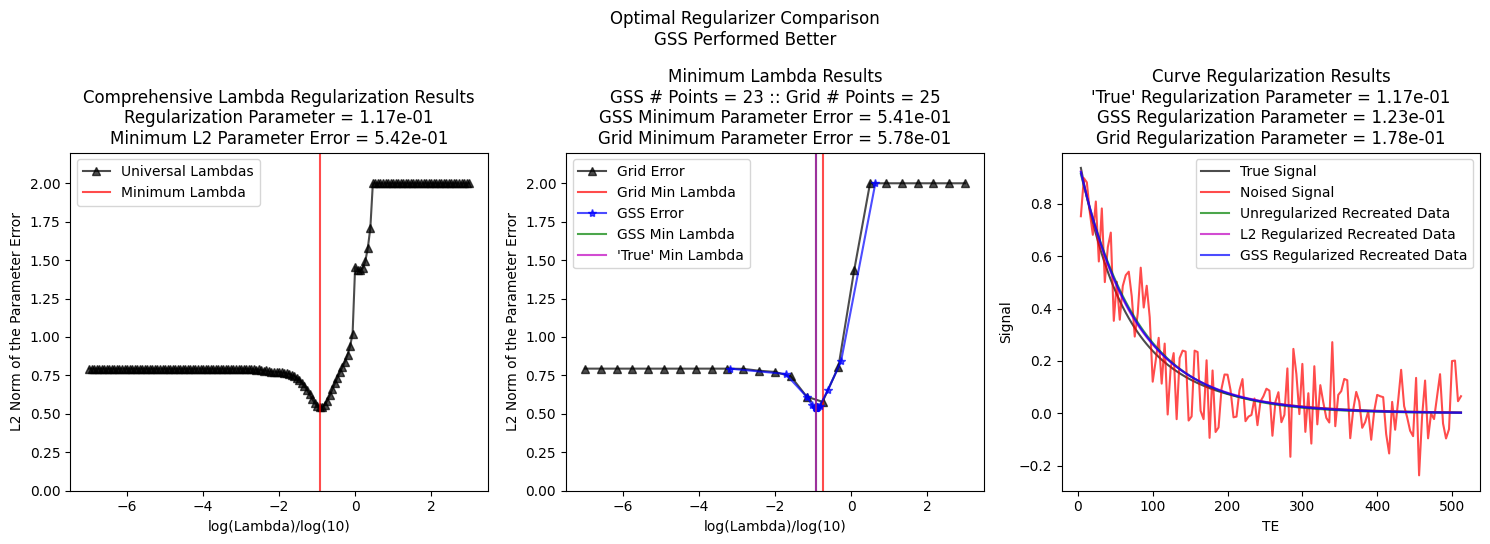

'Unreg RSS L2 0.035560583975006735'

'GSS RSS L2 0.026486622364783805'

'Grid RSS L2 0.020443358682274204'

'------------------------------------'

'Unreg RSS L1 1.3695785963654101'

'GSS RSS L1 1.1400232837090902'

'Grid RSS L1 1.0006654354326183'

'------------------------------------'

'Unreg RSS Noised L2 1.4109606694044081'

'GSS RSS Noised L2 1.416406401300203'

'Grid RSS Noised L2 1.4232073459530477'

In [83]:
noiseless_curve = G(tdata, c1, c2, T21, T22)

data = noiseless_curve + noise(noise_sd_test)

unreg_params = estimate_parameters(data, 0)

opt_params_comp, min_error_lambda_comp, error_array_comp = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_comprehensive)
opt_params_GSS, min_error_lambda_GSS, lambda_list_GSS, error_array_GSS = find_minLambda_GSS_omni(data, c1, c2, T21, T22)
opt_params_grid, min_error_lambda_grid, error_array_grid = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_test)

lamda_list_ind_sort = np.argsort(lambda_list_GSS)
lambda_list_sorted = np.take_along_axis(np.array(lambda_list_GSS), lamda_list_ind_sort, axis=0)
error_array_sorted = np.take_along_axis(np.array(error_array_GSS), lamda_list_ind_sort, axis=0)

unreg_curve = G(tdata, *unreg_params)
recreated_curve_GSS = G(tdata, *opt_params_GSS)
recreated_curve_grid = G(tdata, *opt_params_grid)


###Calculating lots of RSS metrics to evaluate fit on final curves...
unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2)
recreated_RSS_GSS = np.sum((noiseless_curve - recreated_curve_GSS)**2)
recreated_RSS_grid = np.sum((noiseless_curve - recreated_curve_grid)**2)

unreg_RSS_L1 = np.sum(np.abs(noiseless_curve - unreg_curve))
recreated_RSS_GSS_L1 = np.sum(np.abs(noiseless_curve - recreated_curve_GSS))
recreated_RSS_grid_L1 = np.sum(np.abs(noiseless_curve - recreated_curve_grid))

unreg_RSS_noised = np.sum((data - unreg_curve)**2)
recreated_RSS_GSS_noised = np.sum((data - recreated_curve_GSS)**2)
recreated_RSS_grid_noised = np.sum((data - recreated_curve_grid)**2)

### Figure Results

opt_ymax = 1.1*np.max([np.max(error_array_grid),np.max(error_array_GSS),np.max(error_array_comp)])

fig, ax = plt.subplots(1,3,figsize=(15,5.5), tight_layout=True)
ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=np.log10(min_error_lambda_comp), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[0].set_xlabel('log(Lambda)/log(10)')
ax[0].set_ylabel('L2 Norm of the Parameter Error')
ax[0].set_ylim((0,opt_ymax))
ax[0].set_title('Comprehensive Lambda Regularization Results' + 
                '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_comp) + '\nMinimum L2 Parameter Error = {:.2e}'.format(np.min(error_array_comp)))
ax[0].legend()


ax[1].plot(np.log10(lambdas_test), error_array_grid, label = 'Grid Error', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axvline(x=np.log10(min_error_lambda_grid), label = 'Grid Min Lambda', alpha = 0.7, color ='r', ls = '-')
ax[1].plot(np.log10(lambda_list_sorted), error_array_sorted, label = 'GSS Error', alpha = 0.7, color ='b', ls = '-', marker = '*')
ax[1].axvline(x=np.log10(min_error_lambda_GSS), label = 'GSS Min Lambda', alpha = 0.7, color ='g', ls = '-')
ax[1].axvline(x=np.log10(min_error_lambda_comp), label = "'True' Min Lambda", alpha = 0.7, color ='m', ls = '-')
ax[1].set_xlabel('log(Lambda)/log(10)')
ax[1].set_ylabel('L2 Norm of the Parameter Error')
ax[1].set_ylim((0,opt_ymax))
ax[1].set_title('Minimum Lambda Results' + 
                '\nGSS # Points = ' + str(np.size(lambda_list_sorted)) + ' :: Grid # Points = ' + str(np.size(lambdas_test)) +
                '\nGSS Minimum Parameter Error = {:.2e}'.format(error_array_GSS[-1]) + 
                '\nGrid Minimum Parameter Error = {:.2e}'.format(np.min(error_array_grid)))
ax[1].legend()


ax[2].plot(tdata, noiseless_curve, label = 'True Signal', alpha = 0.7, color ='k', ls = '-')
ax[2].plot(tdata, data, label = 'Noised Signal', alpha = 0.7, color ='r', ls = '-')
ax[2].plot(tdata, unreg_curve, label = 'Unregularized Recreated Data', alpha = 0.7, color ='g', ls = '-')
ax[2].plot(tdata, recreated_curve_grid, label = 'L2 Regularized Recreated Data', alpha = 0.7, color ='m', ls = '-')
ax[2].plot(tdata, recreated_curve_GSS, label = 'GSS Regularized Recreated Data', alpha = 0.7, color ='b', ls = '-')
ax[2].set_xlabel('TE')
ax[2].set_ylabel('Signal')
ax[2].set_title('Curve Regularization Results' + 
                "\n'True' Regularization Parameter = " + "{:.2e}".format(min_error_lambda_comp) +
                '\nGSS Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_GSS) + 
                '\nGrid Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_grid))
ax[2].legend()

if abs(min_error_lambda_GSS - min_error_lambda_comp) < abs(min_error_lambda_grid - min_error_lambda_comp):
    fig.suptitle("Optimal Regularizer Comparison" + '\nGSS Performed Better')
else:
    fig.suptitle("Optimal Regularizer Comparison" + '\nGrid Performed Better')

plt.show()

### Output for all RSS metrics
display(f"Unreg RSS L2 {unreg_RSS}")
display(f"GSS RSS L2 {recreated_RSS_GSS}")
display(f"Grid RSS L2 {recreated_RSS_grid}")
display("------------------------------------")
display(f"Unreg RSS L1 {unreg_RSS_L1}")
display(f"GSS RSS L1 {recreated_RSS_GSS_L1}")
display(f"Grid RSS L1 {recreated_RSS_grid_L1}")
display("------------------------------------")
display(f"Unreg RSS Noised L2 {unreg_RSS_noised}")
display(f"GSS RSS Noised L2 {recreated_RSS_GSS_noised}")
display(f"Grid RSS Noised L2 {recreated_RSS_grid_noised}")

## Compare Three Methods for Optimal Lambda
1. Un reg
2. L2 Grid Search
2. L2 GSS

### Generate Simulation Data (For multiple samples)

In [84]:
def shuffle(tens):
    idx = torch.randperm(tens.size(0))
    new_tens = tens[idx]
    # new_tens = np.random.permutation(tens)
    if torch.equal(new_tens, tens):
        shuffle(tens)
    else:
        return new_tens

In [85]:
num_samples = 100

#Make cartesian product and convert to Tensor
triplets = product(c1_set, c2_set, T21_set, T22_set)
new_triplets = np.array([x for x in triplets])
tensor_targ_iter = torch.from_numpy(new_triplets)

# Enforce T21 <= T22
mask = torch.gt(tensor_targ_iter[:,2], tensor_targ_iter[:,3])
tensor_targ_iter[mask,2] = tensor_targ_iter[mask,3]

#Randomly shuffle the result
tensor_targ_iter = shuffle(tensor_targ_iter)

simulation_set = tensor_targ_iter[:num_samples]

### Run Simulations (One Sample - num_simulations of Noise Realizations)

In [77]:
# for c1, c2, T21, T22 in tqdm()
num_simulations = 100
num_decimals = 5

noise_sd = 1/10

lamb_thresh = 10**-4


idx_to_type = {0: "Win_GSS", 1: "Win_L2_Grid"}

type_to_count = {"Win_GSS" : 0, "Win_L2_Grid": 0, "Tie" : 0}


noiseless_curve = G(tdata, c1, c2, T21, T22)

difference_matrix = np.ndarray((num_simulations,2))

for i in tqdm(range(num_simulations)): #noise realizations
    np.random.seed(i)
    data = noiseless_curve + noise(noise_sd)
    #For brain data, normalize so that the first point is at 1
    # datasets.append(data)
    unreg_params = estimate_parameters(data, 0)

    opt_params_comp, min_error_lambda_comp, error_array_comp = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_comprehensive)
    opt_params_GSS, min_error_lambda_GSS, lambda_list_GSS, error_array_GSS = find_minLambda_GSS_omni(data, c1, c2, T21, T22)
    opt_params_grid, min_error_lambda_grid, error_array_grid = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_test)

    unreg_curve = G(tdata, *unreg_params)
    recreated_curve_GSS = G(tdata, *opt_params_GSS)
    recreated_curve_grid = G(tdata, *opt_params_grid)

    unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2).round(decimals = num_decimals)
    recreated_RSS_GSS = np.sum((noiseless_curve - recreated_curve_GSS)**2).round(decimals = num_decimals)
    recreated_RSS_grid = np.sum((noiseless_curve - recreated_curve_grid)**2).round(decimals = num_decimals)


    compare = np.array(np.abs([min_error_lambda_GSS, min_error_lambda_grid] - min_error_lambda_comp))
    compare = compare.round(decimals = num_decimals)
    idx = np.argmin(compare)

    difference_matrix[i,0] = min_error_lambda_GSS - min_error_lambda_comp
    difference_matrix[i,1] = min_error_lambda_grid - min_error_lambda_comp

    out = np.where(compare == compare[idx])
    splice = compare[out] 
    splice_size = len(splice)
    match splice_size:
        case 2:
            type_to_count["Tie"] +=1
        case _:
            type_to_count[idx_to_type[idx]] +=1


display("Mean difference (GSS lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[0])
display("Mean difference (grid lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[1])

display(type_to_count)




100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


'Mean difference (GSS lambda - true lambda):\n'

-0.002600009961220383

'Mean difference (grid lambda - true lambda):\n'

0.019216322329312634

{'Win_GSS': 86, 'Win_L2_Grid': 14, 'Tie': 0}